In [58]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [59]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%Y-%m-%d"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [60]:
#URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

stateURL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

In [61]:
raw_states = Table.read_table(stateURL)
states = list(np.unique(raw_states['state']))

In [62]:
cases = TimeTable.from_table(raw_states.pivot('state', 'date', 'cases', sum), time_col = 'date', 
                             time_less_fun=less_day)
deaths = TimeTable.from_table(raw_states.pivot('state', 'date', 'deaths', sum), time_col = 'date',
                             time_less_fun=less_day)

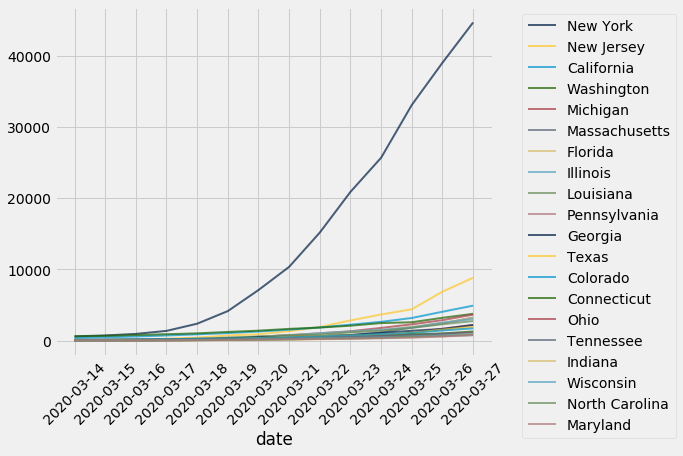

In [63]:
cases.top(20).take[-14:].plot('date', width=7, height=6)
_ = plots.xticks(rotation=45)

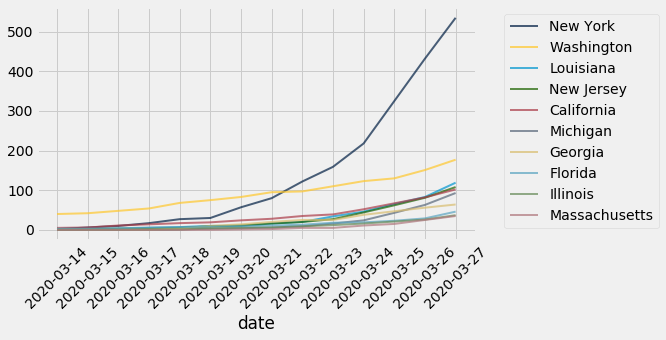

In [64]:
deaths.top(10).take[-14:].plot('date', width=7)
_ = plots.xticks(rotation=45)

In [65]:
def show_st(state='California'):
    watch_state = state
    cases.extract(state).trend().take[-10:].show()
    cases.extract(state).trend().select(['date', state, 'new']).take[-20:].plot('date', width=7)
    _ = plots.xticks(rotation=45)

_ = interact(show_st, state=states)

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

In [66]:
def proj_st(state):
    proj = project_trend(cases.extract(state).trend().take[-7:], 14)
    proj.show()
    proj.select(['date', state, 'new']).plot('date', width = 7)
    last = cases['date'][-1]
    plots.plot([last, last], [0, proj[state][-1]])
    _ = plots.xticks(rotation=45)
_ = interact(proj_st, state=states)

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…

In [67]:
def proj_st_deaths(state):
    proj = project_trend(deaths.extract(state).trend().take[-7:], 14)
    proj.show()
    proj.select(['date', state, 'new']).plot('date', width = 7)
    last_day = deaths['date'][-1]
    current = deaths[state]
    last_val = proj[state][-1]
    plots.plot([last_day, last_day], [0, last_val])
    _ = plots.xticks(rotation=45)
    
_ = interact(proj_st_deaths, state=states)

interactive(children=(Dropdown(description='state', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cali…